# Deep Learning for Tumor Classification using RNA expression and H50 signaling pathways

We show how to train a NN model to predict tumor classes from RNA expression and H50 signaling pathways using TCGA samples.


The model achieved 0.96 accuracy predicting 33 different tumor types in a validation set of 3000 samples. This result exceed those reported in [1,2] The confussion matrix, shows that the model almost only failed to discriminate rectal from colon cancer and esophageal from stomach cancer, which are closely related hysthologically.

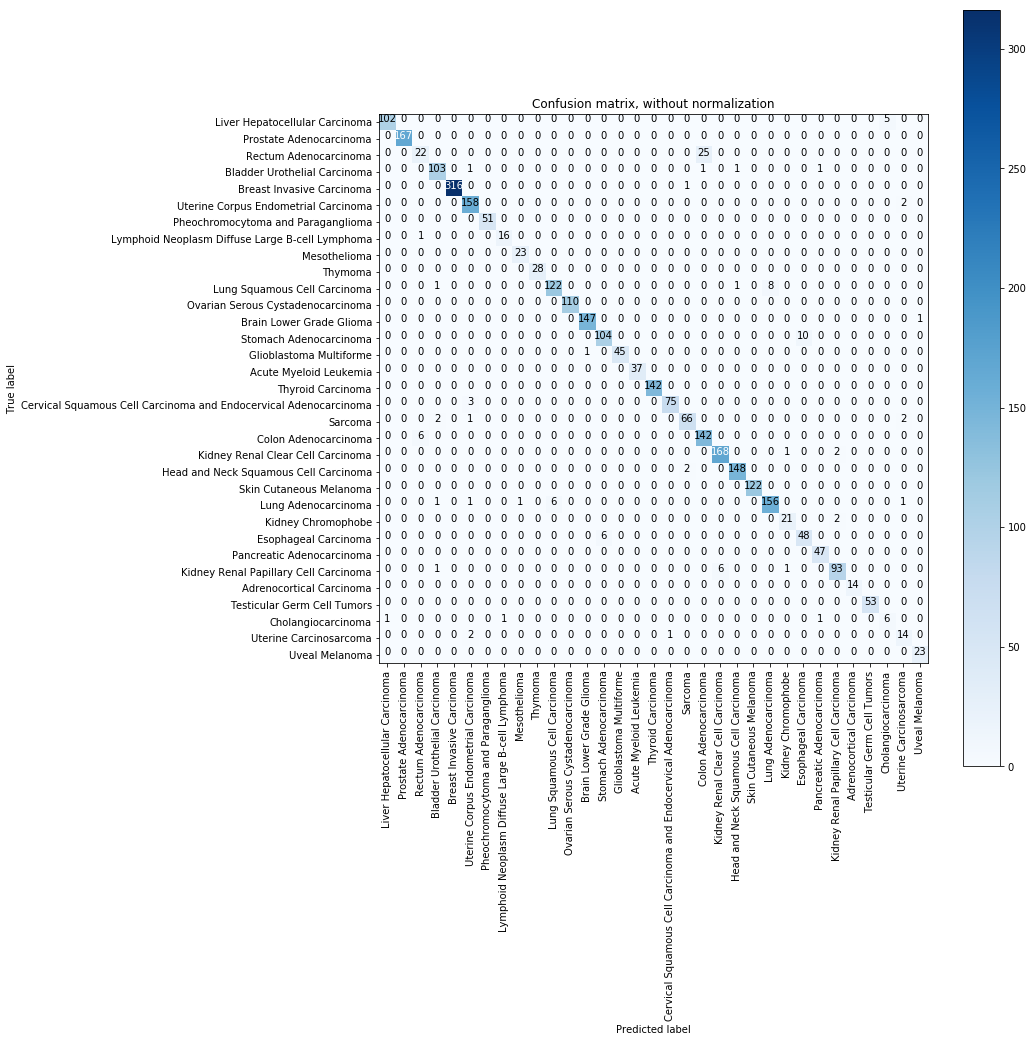

In [71]:
#Confussion Matrix
from IPython.display import Image
Image("TumorClassification_RNAexp.png")

# Predicting tumor types 
The following section shows how to train a NN model to predict tumor classes from RNA expression and H50 signaling pathways using TCGA samples. 
To download the required data and generate the files from scratch see section [Data Preprocessing](#prep)
This notebook is inspired in [@alenaharley article](https://medium.com/@alenaharley/tumor-classification-using-gene-expression-data-poking-at-a-problem-using-fast-ai-again-8633c2256c85) 

In [1]:
#This section requires preprocessed files. 
import pandas as pd
H50 = pd.read_csv('h.all.v6.2.symbols.gmt', header = None, sep='\t')
df_categories = pd.read_pickle('RNAexp_H50cat_tumorTypes.pkl')
df_categories.describe()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,cancercat
count,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,...,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000
mean,14.511335,14.658286,7.818664,21.170343,16.323402,11.515712,10.927732,3.512874,16.375104,4.546174,...,16.803166,14.481343,16.262297,17.164771,11.034740,17.568689,19.878162,18.062571,17.549486,15.014002
std,2.262990,1.781519,7.636277,1.819773,1.530948,5.025257,2.047451,7.174155,1.840625,7.976631,...,1.550544,1.295317,1.108982,0.948553,4.794702,1.120799,1.148660,1.065064,0.987241,9.301482
min,4.906939,4.392386,-9.965784,10.540129,8.876520,-9.965784,-9.965784,-9.965784,6.988696,-9.965784,...,8.906894,-9.965784,7.584970,11.969387,-9.965784,10.388018,14.118455,12.988152,11.607331,0.000000
25%,13.115125,13.612897,6.247946,20.103902,15.396688,8.640249,10.006678,3.322072,15.161555,4.807406,...,15.698264,13.734075,15.639362,16.617780,9.012625,16.962933,19.163031,17.430391,16.973854,7.000000
50%,14.377075,14.614969,7.936644,21.240994,16.313299,10.918491,11.040290,6.584978,16.524121,7.584970,...,16.862601,14.602264,16.340676,17.227212,11.866893,17.655066,19.896538,18.149090,17.624513,14.000000
75%,15.611969,15.556147,11.956830,22.350001,17.271283,14.611140,12.092427,8.029291,17.722402,9.205794,...,17.988194,15.369069,16.953637,17.761895,14.115450,18.333242,20.566523,18.753259,18.193407,23.000000
max,25.744343,23.457815,21.781484,27.526837,22.749258,25.852982,18.892860,14.192447,21.365289,20.369699,...,21.309852,17.978504,20.607729,20.899094,21.113483,22.043753,24.416677,22.150687,21.651597,32.000000


In [2]:
#Use FastAI 
from fastai import *
from fastai.tabular import * 

#reserve a random sample of 3000 samples to validate the model
valid_idx = np.random.choice(len(df_categories), 3000, replace=False)
#Normalize continous variables
procs = [FillMissing, Categorify, Normalize]

#name of the dependent variable for the tumor classes to predict
dep_var = 'cancertype'
#name of categorical variables: 50 binary variables corresponding to the H50 pathways indicating if the pathway is activated or not in the tumor sample 
cat_names = H50.loc[:,0].values #in fastAI all other fields not in dep_var or cat_names are handled as continous variables
#name of continous variables: 25K continous variables containing to the log2 of RNA expression for each gene in the sample
cont_names = np.setdiff1d(list(df_categories.columns), list(cat_names) + [dep_var, 'cancercat'])


In [3]:
class_names = list(df_categories.cancertype.cat.categories)
print(class_names)

['Acute Myeloid Leukemia', 'Adrenocortical Carcinoma', 'Bladder Urothelial Carcinoma', 'Brain Lower Grade Glioma', 'Breast Invasive Carcinoma', 'Cervical Squamous Cell Carcinoma and Endocervical Adenocarcinoma', 'Cholangiocarcinoma', 'Colon Adenocarcinoma', 'Esophageal Carcinoma', 'Glioblastoma Multiforme', 'Head and Neck Squamous Cell Carcinoma', 'Kidney Chromophobe', 'Kidney Renal Clear Cell Carcinoma', 'Kidney Renal Papillary Cell Carcinoma', 'Liver Hepatocellular Carcinoma', 'Lung Adenocarcinoma', 'Lung Squamous Cell Carcinoma', 'Lymphoid Neoplasm Diffuse Large B-cell Lymphoma', 'Mesothelioma', 'Ovarian Serous Cystadenocarcinoma', 'Pancreatic Adenocarcinoma', 'Pheochromocytoma and Paraganglioma', 'Prostate Adenocarcinoma', 'Rectum Adenocarcinoma', 'Sarcoma', 'Skin Cutaneous Melanoma', 'Stomach Adenocarcinoma', 'Testicular Germ Cell Tumors', 'Thymoma', 'Thyroid Carcinoma', 'Uterine Carcinosarcoma', 'Uterine Corpus Endometrial Carcinoma', 'Uveal Melanoma']


### First Experiment: train a [model](#prep) using RNA exp + signaling pathways

In [4]:
data = TabularDataBunch.from_df('./', df_categories, 
                                dep_var=dep_var, valid_idx=valid_idx, procs=procs, 
                                cat_names=cat_names, cont_names=cont_names)

In [5]:
#print(data.train_ds.cont_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}

learn = tabular_learner(data, layers=[1024,516,128,64], metrics=accuracy, ps=[.2,.2,.2,.2])


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


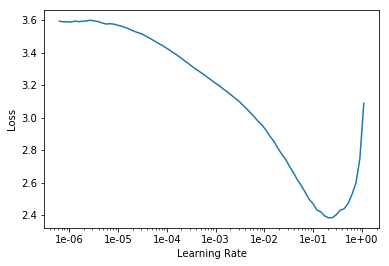

In [6]:
learn.lr_find()
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(10, 1e-2)
learn.save('tumorClassifierFastAI')

Total time: 00:49
epoch  train_loss  valid_loss  accuracy
1      1.071876    0.357942    0.909000  (00:04)
2      0.403538    0.248604    0.914333  (00:04)
3      0.305325    0.304598    0.914667  (00:04)
4      0.238887    0.270671    0.912667  (00:04)
5      0.152964    0.231212    0.934333  (00:04)
6      0.115090    0.172455    0.944667  (00:04)
7      0.083138    0.152248    0.951667  (00:04)
8      0.040459    0.156743    0.954667  (00:04)
9      0.018306    0.160180    0.959333  (00:04)
10     0.012852    0.152014    0.963000  (00:04)



In [8]:
y_pred = learn.get_preds()
y_pred = np.argmax(y_pred[0].numpy(), axis=1)

In [62]:
y = data.valid_ds.y.items

m = pd.DataFrame({'code': y, 'label': [x for x in data.valid_ds.y] })
d = m.drop_duplicates(subset='code')
d = d.sort_values(by=['code'])
class_names = d.label.values



Automatically created module for IPython interactive environment
Confusion matrix, without normalization


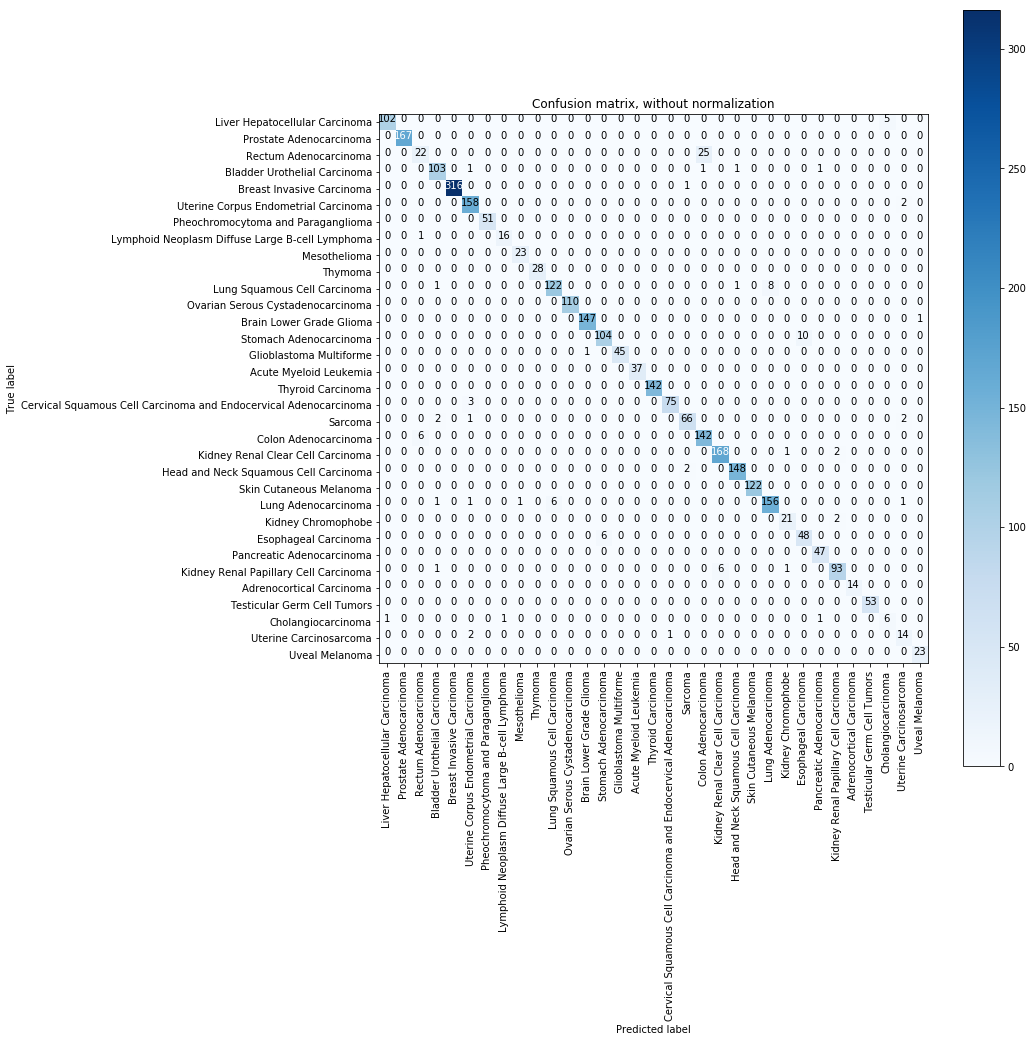

In [63]:
print(__doc__)
import sklearn
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#np.set_printoptions(threshold=np.nan)
from pylab import rcParams
rcParams['figure.figsize'] = 15,15



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    #print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=90)
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()


In [27]:

#Validation set
df_categories.iloc[valid_idx.tolist(),df_categories.columns.get_loc('cancertype')].value_counts()

Breast Invasive Carcinoma                                           317
Kidney Renal Clear Cell Carcinoma                                   171
Prostate Adenocarcinoma                                             167
Lung Adenocarcinoma                                                 166
Uterine Corpus Endometrial Carcinoma                                160
Head and Neck Squamous Cell Carcinoma                               150
Brain Lower Grade Glioma                                            148
Colon Adenocarcinoma                                                148
Thyroid Carcinoma                                                   142
Lung Squamous Cell Carcinoma                                        132
Skin Cutaneous Melanoma                                             122
Stomach Adenocarcinoma                                              114
Ovarian Serous Cystadenocarcinoma                                   110
Bladder Urothelial Carcinoma                                    

### Second Experiment: remove input from signaling pathways and use only RNA exp

In [64]:
data = TabularDataBunch.from_df('./', df_categories, 
                                dep_var=dep_var, valid_idx=valid_idx, procs=procs, 
                                cat_names=[], cont_names=cont_names)

In [65]:
#print(data.train_ds.cont_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}

learn = tabular_learner(data, layers=[1024,516,128,64], metrics=accuracy, ps=[.2,.2,.2,.2])


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


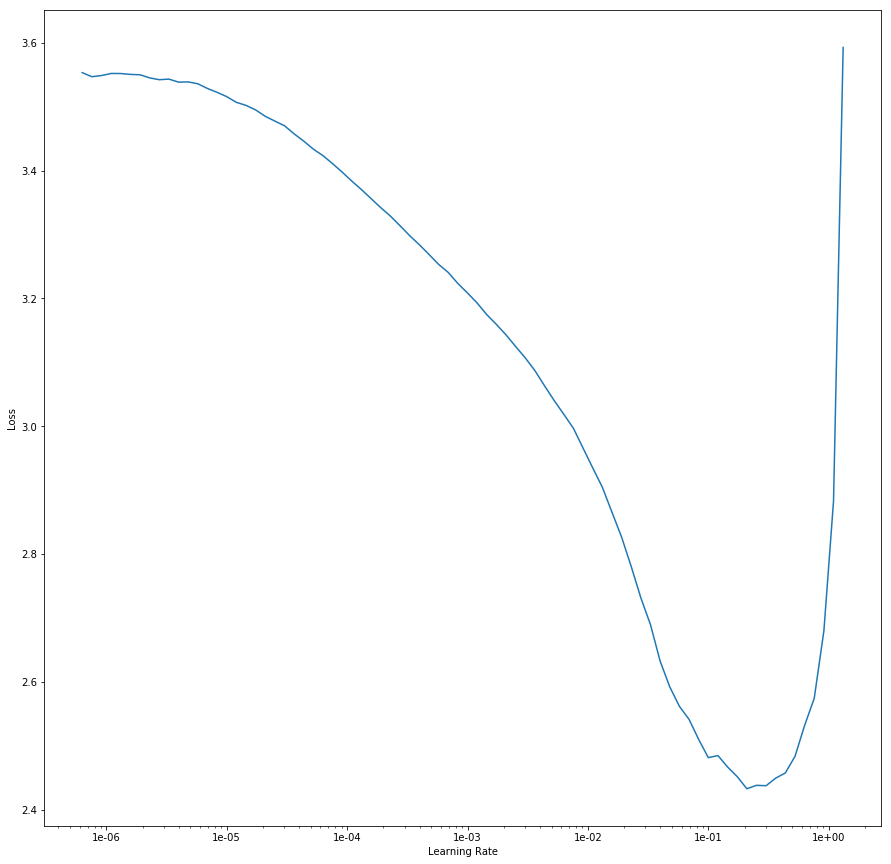

In [66]:
learn.lr_find()
learn.recorder.plot()

In [67]:
learn.fit_one_cycle(10, 1e-2)
learn.save('tumorClassifierFastAI')

Total time: 00:47
epoch  train_loss  valid_loss  accuracy
1      1.125185    0.393269    0.897000  (00:04)
2      0.411790    0.272298    0.921333  (00:04)
3      0.284616    0.282682    0.923333  (00:04)
4      0.207195    0.240883    0.927333  (00:04)
5      0.167336    0.229546    0.928333  (00:04)
6      0.110502    0.243625    0.929000  (00:04)
7      0.081649    0.156840    0.953000  (00:04)
8      0.052377    0.143791    0.959333  (00:04)
9      0.040370    0.140383    0.958333  (00:04)
10     0.030391    0.142785    0.959000  (00:04)



### Model Topology 
<a id='model'></a>

In [56]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(25150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=25150, out_features=1024, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2)
    (4): Linear(in_features=1024, out_features=516, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(516, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2)
    (8): Linear(in_features=516, out_features=128, bias=True)
    (9): ReLU(inplace)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU(inplace)
    (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.2)
    (16

In [68]:
y_pred = learn.get_preds()
y_pred = np.argmax(y_pred[0].numpy(), axis=1)

In [69]:
y = data.valid_ds.y.items

m = pd.DataFrame({'code': y, 'label': [x for x in data.valid_ds.y] })
d = m.drop_duplicates(subset='code')
d = d.sort_values(by=['code'])
class_names = d.label.values

Automatically created module for IPython interactive environment
Confusion matrix, without normalization


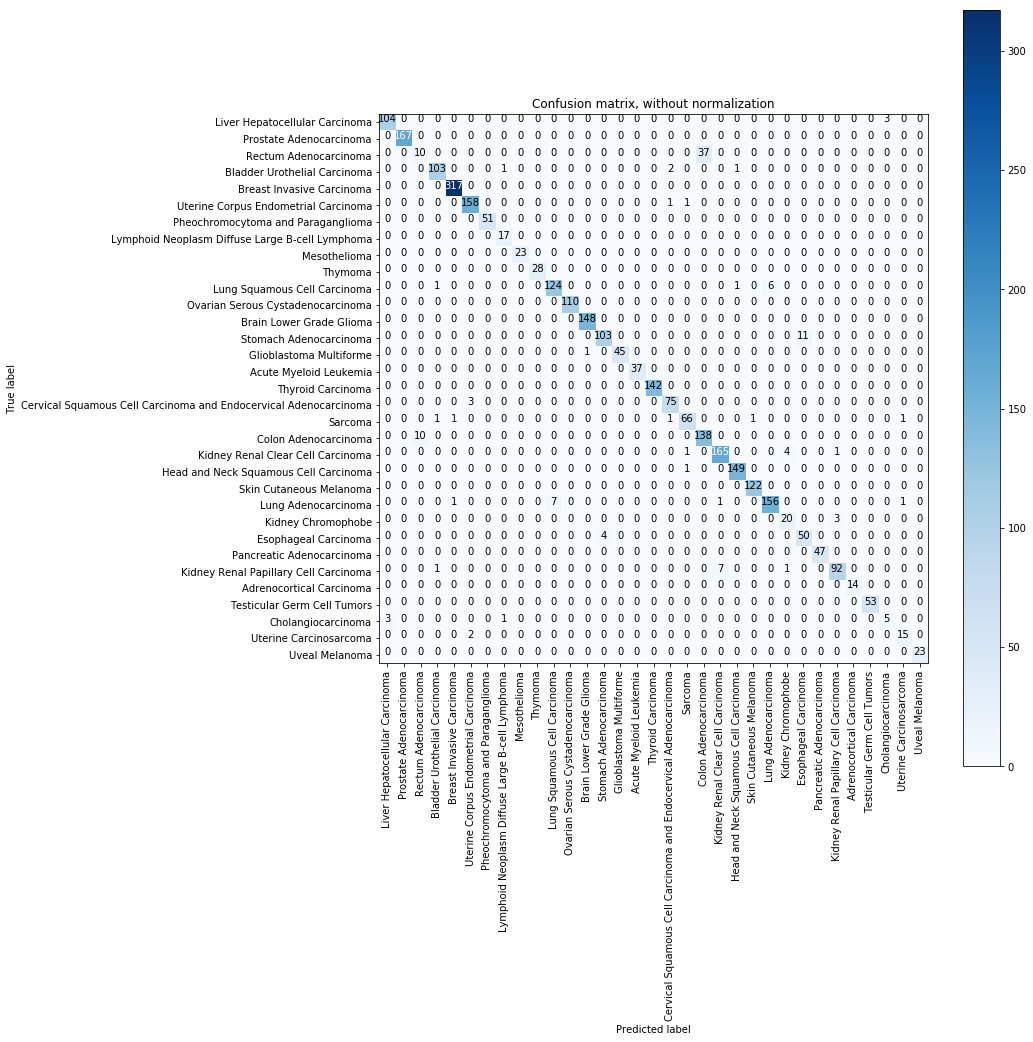

In [70]:
print(__doc__)
import sklearn
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#np.set_printoptions(threshold=np.nan)
from pylab import rcParams
rcParams['figure.figsize'] = 15,15


# Compute confusion matrix
cnf_matrix = confusion_matrix(y, y_pred)
np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


plt.show()


In [65]:
row = df_categories.iloc[52]
learn.predict(row)


(31,
 tensor(6),
 tensor([4.2717e-06, 2.3154e-06, 7.4061e-07, 1.9717e-05, 2.4829e-08, 4.3415e-07,
         9.9986e-01, 5.7460e-10, 1.3946e-05, 9.6211e-08, 3.7760e-07, 8.5407e-08,
         2.0124e-06, 6.8098e-06, 2.7512e-06, 1.5385e-07, 6.3460e-08, 7.1756e-09,
         3.2403e-08, 1.6407e-05, 6.4813e-07, 1.3447e-07, 7.1733e-09, 1.3105e-07,
         6.6687e-06, 5.8773e-07, 6.0080e-08, 6.9000e-07, 2.1876e-05, 3.3902e-06,
         2.6645e-06, 1.4633e-07, 2.9564e-05]))

In [66]:
row.cancertype

'Uterine Corpus Endometrial Carcinoma'

## Data Preprocessing and file generation 
<a id='prep'></a>

In [27]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import h5py
import numpy as np

In [6]:
#Importing TCGA RNA expression data downloaded from  https://amp.pharm.mssm.edu/archs4/download.html
filename = "tcga_matrix.h5"

h5 = h5py.File(filename,'r')
for k in h5.keys():
    print(k)


meta = h5['meta']  
dat = h5['data']  
info = h5['info']  



#Showing which type of data it contains    
for s in meta.keys():
    print(s)
    print(meta[s].shape)
    print(meta[s].value)
    
for s in dat.keys():
    print(s)
    print(dat[s].shape)
    print(dat[s].value)    
    
for s in info.keys():
    print(s)
    print(info[s].shape)
    print(info[s].value)    

#h5.close()

meta
data
info
auc
(11284,)
[b'3116748351' b'5069849036' b'4882401623' ... b'5742234142' b'6773612787'
 b'7613399024']
bigwig_file
(11284,)
[b'3DFF72D2-F292-497E-ACE3-6FAA9C884205.bw'
 b'B1E54366-42B9-463C-8615-B34D52BD14DC.bw'
 b'473713F7-EB41-4F20-A37F-ACD209E3CB75.bw' ...
 b'76987B28-B56B-4A1F-B77C-1E08B8EFEF90.bw'
 b'33737781-8638-4FA2-AD4C-E888BB9343D8.bw'
 b'0BB05CA7-C6FF-42A1-919C-D801F471CBBD.bw']
cancertype
(11284,)
[b'Liver Hepatocellular Carcinoma' b'Prostate Adenocarcinoma'
 b'Rectum Adenocarcinoma' ... b'Brain Lower Grade Glioma'
 b'Acute Myeloid Leukemia' b'Thyroid Carcinoma']
gdc_annotations
(11284,)
[b'NULL' b'NULL' b'NULL' ... b'NULL'
 b'list(category = "Alternate sample pipeline", status = "Approved", entity_id = "fff35c80-88cd-4923-80c1-0273ba5bed0f", classification = "Notification", updated_datetime = "2016-05-01T15:00:21.638875-05:00", created_datetime = "2012-11-13T12:37:22-05:00", entity_submitter_id = "TCGA-AB-2881", notes = "Biospecimens from this case belong t

author
(1,)
[b'Alexander Lachmann']
contact
(1,)
[b'alexander.lachmann@mssm.edu']
countsource
(1,)
[b'recount2: https://jhubiostatistics.shinyapps.io/recount/']
creationdate
(1,)
[b'10/9/2017']
lab
(1,)
[b"Ma'ayan Lab, Icahn School of Medicine"]


In [7]:
#Importing pathway enrichment analysis for 50 Cancer Hallmark pathways http://software.broadinstitute.org/gsea/msigdb/collections.jsp#H
#In gmt format each gene set is a row and is described by a name, a description, and the genes in the gene set
import pandas as pd

H50 = pd.read_csv('h.all.v6.2.symbols.gmt', header = None, sep='\t')
H50.head()


,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,HALLMARK_TNFA_SIGNALING_VIA_NFKB,http://www.broadinstitute.org/gsea/msigdb/card...,JUNB,CXCL2,ATF3,NFKBIA,TNFAIP3,PTGS2,CXCL1,IER3,...,EIF1,BMP2,DUSP4,PDLIM5,ICOSLG,GFPT2,KLF2,TNC,SERPINB8,MXD1
1,HALLMARK_HYPOXIA,http://www.broadinstitute.org/gsea/msigdb/card...,PGK1,PDK1,GBE1,PFKL,ALDOA,ENO2,PGM1,NDRG1,...,HDLBP,ILVBL,NCAN,TGM2,ETS1,HOXB9,SELENBP1,FOSL2,SULT2B1,TGFB3
2,HALLMARK_CHOLESTEROL_HOMEOSTASIS,http://www.broadinstitute.org/gsea/msigdb/card...,FDPS,CYP51A1,IDI1,FDFT1,DHCR7,SQLE,HMGCS1,NSDHL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HALLMARK_MITOTIC_SPINDLE,http://www.broadinstitute.org/gsea/msigdb/card...,ARHGEF2,CLASP1,KIF11,KIF23,ALS2,ARF6,MYO9B,MYH9,...,RHOT2,SORBS2,CDC42EP1,VCL,CLIP1,STK38L,YWHAE,RAPGEF5,CEP72,CSNK1D
4,HALLMARK_WNT_BETA_CATENIN_SIGNALING,http://www.broadinstitute.org/gsea/msigdb/card...,MYC,CTNNB1,JAG2,NOTCH1,DLL1,AXIN2,PSEN2,FZD1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Add H50 gen sets as a categorical variable 

In [14]:
#Different genes involved in 50 selected signaling pathways 
genePath_set = pd.unique(H50.loc[:,2:].values.ravel('K'))

f'The number of unique genes involved in the 50 selected signaling pathways is {genePath_set.size}.'

'The number of unique genes involved in the 50 selected signaling pathways is 4387.'

In [13]:
f'H50 contains {H50.shape[0]} signaling pathways composed of a set of {H50.shape[1]} genes'

'H50 contains 50 signaling pathways composed of a set of 202 genes'

In [16]:
#if not exists it saves a file 'log2expression.npy' with the log2 transformation of RNA expression 
import os.path
def f(x):
    #return log2(TPM+0.001)
    return np.log2(x +0.001 ) 

l = None
if not os.path.exists('log2expression.npy'):
    #log2(TPM+0.001) expression values computed per gene
    l = dat['expression'].value
    l = np.vectorize(f)(l)
    np.save('log2expression.npy', l)
else: 
    l = np.load('log2expression.npy')

from scipy import stats
stats.describe(l)


DescribeResult(nobs=11284, minmax=(array([ 4.90693868,  4.39238612, -9.96578428, ..., 14.11845455,
       12.98815228, 11.60733078]), array([25.74434345, 23.45781508, 21.78148379, ..., 24.41667745,
       22.1506869 , 21.65159744])), mean=array([14.51133518, 14.65828565,  7.81866386, ..., 19.87816157,
       18.0625713 , 17.54948585]), variance=array([ 5.12112323,  3.17381026, 58.31272768, ...,  1.31941998,
        1.13436237,  0.97464454]), skewness=array([ 1.34799737,  1.15626794, -0.97460423, ..., -0.09400296,
       -0.34315363, -0.48017077]), kurtosis=array([4.18004613, 4.2873423 , 0.95231487, ..., 0.81602377, 0.62193682,
       0.94856403]))

In [17]:
#associate gene names with RNA expression
def f(x):
    return x.decode("utf-8")
genes = np.vectorize(f)(meta['genes'].value)
df = pd.DataFrame(l, columns = genes)
df.describe()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
count,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,...,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000,11284.000000
mean,14.511335,14.658286,7.818664,21.170343,16.323402,11.515712,10.927732,3.512874,16.375104,4.546174,...,16.317508,16.803166,14.481343,16.262297,17.164771,11.034740,17.568689,19.878162,18.062571,17.549486
std,2.262990,1.781519,7.636277,1.819773,1.530948,5.025257,2.047451,7.174155,1.840625,7.976631,...,1.238517,1.550544,1.295317,1.108982,0.948553,4.794702,1.120799,1.148660,1.065064,0.987241
min,4.906939,4.392386,-9.965784,10.540129,8.876520,-9.965784,-9.965784,-9.965784,6.988696,-9.965784,...,9.238407,8.906894,-9.965784,7.584970,11.969387,-9.965784,10.388018,14.118455,12.988152,11.607331
25%,13.115125,13.612897,6.247946,20.103902,15.396688,8.640249,10.006678,3.322072,15.161555,4.807406,...,15.450841,15.698264,13.734075,15.639362,16.617780,9.012625,16.962933,19.163031,17.430391,16.973854
50%,14.377075,14.614969,7.936644,21.240994,16.313299,10.918491,11.040290,6.584978,16.524121,7.584970,...,16.299789,16.862601,14.602264,16.340676,17.227212,11.866893,17.655066,19.896538,18.149090,17.624513
75%,15.611969,15.556147,11.956830,22.350001,17.271283,14.611140,12.092427,8.029291,17.722402,9.205794,...,17.199718,17.988194,15.369069,16.953637,17.761895,14.115450,18.333242,20.566523,18.753259,18.193407
max,25.744343,23.457815,21.781484,27.526837,22.749258,25.852982,18.892860,14.192447,21.365289,20.369699,...,20.524677,21.309852,17.978504,20.607729,20.899094,21.113483,22.043753,24.416677,22.150687,21.651597


In [22]:
#One hot 50 signaling pathways for each instance
#1. Select only genes involved in pathways
print(genePath_set)
genePath_I_geneRNA= set(df.columns).intersection(set(genePath_set))
df_s = df[list(genePath_I_geneRNA)]
f'RNA exp gene matrix is reduced to the {df_s.shape[1]} genes involved in pathways'


['JUNB' 'PGK1' 'FDPS' ... 'DYRK3' 'TPH1' 'P2RY4']


'RNA exp gene matrix is reduced to the 4304 genes involved in pathways'

In [ ]:
#2. Add result of pathway enrichment analysis for 50 Cancer Hallmark pathways as categorical variables: 
#Array of 50 boolean
#If all genes involved on each signaling pathway from H50 are RNA log2 expressed > 0 then this pathway is assigned True in the sample
def f(row):
    a = []
    for index, p in H50.iterrows():
        #print(p)
        #exclude from pathway genes 'p' those that are not in genePath_I_geneRNA (Total 83)
        p_s = set(p[2:]).intersection(genePath_I_geneRNA)
        rna = row[list(p_s)]
        #print (rna)
        a.append(np.all(rna.values > 0))
    return np.array(a)
df_s['H50_onehot'] = df_s.apply(f, axis=1)
#Merge H50 onehot with the full RNA expression matrix
df['H50_onehot'] = df_s['H50_onehot'] 
df.to_pickle("RNAexp_H50onehot.pkl")


In [25]:
#Add the ground truth: tumor type for each instance
#Load processed data
df = pd.read_pickle('RNAexp_H50onehot.pkl')

df.loc[:,'cancertype']= pd.Series(np.vectorize(f)(meta['cancertype'].value))
df.head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,H50_onehot,cancertype
0,20.472352,18.746931,18.272466,19.290201,15.257498,-9.965784,9.299210,5.643885,13.595724,-9.965784,...,11.805341,13.000000,15.517669,9.278452,15.699383,18.206232,14.866072,15.448536,"[False, False, False, True, False, False, Fals...",Liver Hepatocellular Carcinoma
1,14.818083,14.545749,7.584970,21.170981,17.082887,13.392988,10.586841,3.322072,17.862692,-9.965784,...,13.460072,15.752668,16.611414,12.744834,16.470659,19.945104,17.252194,16.725619,"[True, False, True, True, True, True, False, T...",Prostate Adenocarcinoma
2,12.077484,13.246592,17.234948,20.949892,14.822969,6.700454,10.472692,7.321937,16.977783,7.044405,...,15.637785,17.493347,16.861135,8.839207,17.636320,20.331971,18.412549,17.949416,"[True, False, True, True, True, True, False, T...",Rectum Adenocarcinoma
3,24.457885,22.684448,19.907039,23.860669,19.778088,7.918869,13.952559,1.000721,16.081317,-9.965784,...,12.749870,15.258603,16.945592,12.561527,18.267911,16.341345,17.340346,17.422426,"[False, False, True, True, True, True, False, ...",Liver Hepatocellular Carcinoma
4,11.676398,12.256504,8.076821,19.457004,14.529736,17.318905,8.209458,-9.965784,17.581149,-9.965784,...,13.757911,15.446534,17.096242,12.186734,17.651276,20.299427,17.006589,17.689343,"[False, False, True, True, False, True, False,...",Bladder Urothelial Carcinoma


In [28]:
H50_categories = pd.DataFrame(df.H50_onehot.tolist(), columns = H50.loc[:,0].values)
df_categories = df.join(H50_categories)
print(df_categories.shape)
df_categories = df_categories.drop(columns=['H50_onehot'])
df_categories['cancertype'] = pd.Categorical(df_categories.cancertype)
df_categories['cancercat'] = df_categories.cancertype.cat.codes #convert cancer types to codes
df_categories.to_pickle("RNAexp_H50cat_tumorTypes.pkl")
df_categories['cancertype'].value_counts()

(11284, 25202)


Breast Invasive Carcinoma                                           1246
Kidney Renal Clear Cell Carcinoma                                    616
Lung Adenocarcinoma                                                  601
Uterine Corpus Endometrial Carcinoma                                 589
Thyroid Carcinoma                                                    572
Prostate Adenocarcinoma                                              558
Lung Squamous Cell Carcinoma                                         555
Head and Neck Squamous Cell Carcinoma                                548
Colon Adenocarcinoma                                                 546
Brain Lower Grade Glioma                                             532
Skin Cutaneous Melanoma                                              473
Stomach Adenocarcinoma                                               453
Bladder Urothelial Carcinoma                                         433
Ovarian Serous Cystadenocarcinoma                  

References:
1. Yuan, Yuchen, et al. "DeepGene: an advanced cancer type classifier based on deep learning and somatic point mutations." BMC bioinformatics 17.17 (2016): 476.
2. https://medium.com/@alenaharley/the-mystery-of-the-origin-cancer-type-classification-using-fast-ai-libray-212eaf8d3f4e 